## Tool Proficiency using Chrome Dino Game

**Resources & References**
1. The Game: https://dinosaurgame.app/ 
2. Video Tutorial: https://www.youtube.com/watch?v=vahwuupy81A&t=5517s
3. Stable-Baselines3 Documentations: https://stable-baselines3.readthedocs.io/en/master/
4. Gymnasium Documentation: https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/
5. PyTorch DQN Documentation for Gym Retro: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html


#### 1. Install dependencies

In [4]:
from mss import mss # for grabbing a screen shot of a monitor
#import pydirectinput # for mouse and keyboard input on windows
import pyautogui # for mouse and keyboard input for multiplatform
import cv2 # for image and video processing
import numpy as np 
import pytesseract # OCR tool for reading text from images
from matplotlib import pyplot as plt
import time 
from gymnasium import Env
from gymnasium.spaces import Box, Discrete # class structures to implement observation and action spaces
from gymnasium.utils import env_checker  # Import the environment checker
from collections import deque

#### 2. Create the Custom Environment

In [216]:
class DinoGame(Env):
    def __init__(self):
        
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(6,50,200), dtype=np.uint8)
        self.action_space = Discrete(3) # number of possible actions
        self.cap = mss()
        # self.game_location = {'top':910, 'left':-2250, 'width':1200, 'height':370} # defines viewing area
        # self.done_location = {'top':240, 'left':-2230, 'width':1800, 'height':300} # defines 'GAME OVER' location    
        # self.obstacle_location = {'top':910, 'left':-1910, 'width':1200, 'height':340} # defines obstacle viewing location
        # self.game_location = {'top':810, 'left':-2250, 'width':1200, 'height':1500} # defines viewing area
        self.game_location = {'top':460, 'left':-2100, 'width':1000, 'height':200}
        self.done_location = {'top':340, 'left':-1630, 'width':700, 'height':100} # defines 'GAME OVER' location    
        self.obstacle_location = {'top':420, 'left':-1810, 'width':300, 'height':200} # defines obstacle viewing location
        self.frame_stack = deque(maxlen=6) # stack frames to provide a sense of motion; DQN benefits from this
        
    # observation of the state of the environment
    def get_observation(self):
        # Get screen capture of game
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        #Grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # Resize
        resized = cv2.resize(gray, (200,50))
        # Add channels first
        channel = np.reshape(resized, (1,50,200))
        return channel
    def get_observation2(self):
        # Get screen capture of game
        raw = np.array(self.cap.grab(self.obstacle_location))[:,:,:3]
        #Grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        
        return raw
    
    def get_stacked_observation(self):
        # stack the frames in the deque and convert to the required shape
        return np.concatenate(list(self.frame_stack), axis=0)
    
    # Get the done text using OCR
    def get_done(self):
        # Get done screen
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        
        # Apply OCR
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res == 'GAME': # NOTE: doesn't recognize 'OVER'
            done = True
        return done, done_cap, res
    
    # Resets the environment to its initial state
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        time.sleep(1)
        pyautogui.click(x=-1385, y=527)
        pyautogui.press('space')
        
        # Reset the frame stack
        self.frame_stack.clear()
        for _ in range(6):
            initial_frame = self.get_observation()
            self.frame_stack.append(initial_frame)
        return self.get_stacked_observation(), {}
    
    
    # Detect objects
    def is_obstacle_nearby(self):
        # Capture current frame
        #current_frame = self.get_observation()
        current_frame = self.get_observation2()
        # Convert to grayscale and resize if necessary
        # gray_frame = current_frame[0, :, :]
        
        # Define a threshold for detecting obstacles
        obstacle_threshold = 200
        obstacle_detected = np.sum(current_frame < obstacle_threshold) > 500
        return obstacle_detected, current_frame
    def get_obstacle_height(self):
        # Capture current frame
        current_frame = np.array(self.cap.grab(self.obstacle_location))[:,:,:3]
        gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, threshold1=100, threshold2=200)
        
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        obstacle_height = 0
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if h > obstacle_height:
                obstacle_height = h
        return obstacle_height
        # 
    # method to take an action as an input and applies it to the environment
    def step(self, action):
        #               Jump        Duck      No Action
        action_map = {0:'space', 1:'down', 2:'no_op'}
        total_reward = 0 
        
        # Check if obstacle is nearby before performing action
        obstacle_nearby = self.is_obstacle_nearby()
        
        # Perform the action
        if action != 2:
            pyautogui.press(action_map[action])
            
        # Checking whether the game is done
        done = self.get_done()

        # Reward - we get a point for every frame we are alive
        reward = 1
        if done:
            reward = -30
        total_reward += reward

        if action == 0:
            if obstacle_nearby:
                total_reward += 10
            if not done:
                total_reward += 40
        elif action == 1:
            if obstacle_nearby:
                total_reward -= 2
        elif action == 2:
            if obstacle_nearby:
                total_reward -= 1
                
        # Get the latest frame
        new_frame = self.get_observation()
        # Update frame stack
        self.frame_stack.append(new_frame)
        # Get stacked observation for the next state
        stacked_observation = self.get_stacked_observation()
        
        return stacked_observation, total_reward, done, False, {}

In [1]:
# import pyautogui
# import time

# print("Move your mouse to the desired position and wait 5 seconds...")
# time.sleep(5)
# x, y = pyautogui.position()
# print(f"Mouse position: x={x}, y={y}")


In [217]:
# instantiate environment
env = DinoGame()

#### 2.1 Testing class methods

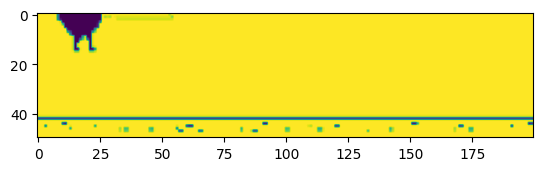

In [218]:
channel = env.get_observation()
plt.imshow(channel[0])

True
GAME


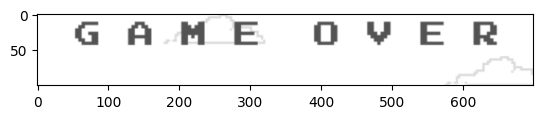

In [73]:
done, frame, res = env.get_done()
print(done)
print(res)
plt.imshow(frame)

In [33]:
obstacle_height = env.get_obstacle_height()
obstacle_height
# dactyl 39 233 152
#small cacti 249 229
#large cacti 360

152

In [ ]:
env.reset()

In [137]:
env.render()

In [174]:
env.close()

In [ ]:
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

In [ ]:
obstacle_detected = env.is_obstacle_nearby()
obstacle_detected

#### 2.2 Testing the Environment

In [ ]:
done = False
while not done:
    obstacle_detected = my_custom_env.is_obstacle_nearby()
    print(f'Obstacle detected: {obstacle_detected}')

In [ ]:
# Play 3 games
for episode in range(3):
    obs = my_custom_env.reset()
    done =False
    total_reward = 0
    
    while not done:
        obs, reward, done, _, info = my_custom_env.step(my_custom_env.action_space.sample())
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')

### 3. Training NN

In [45]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [18]:
# validates the custom environment and ensures it complies with the interface and conventions
env_checker.check_env(my_custom_env)

In [46]:
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True
    
CHECKPOINT_DIR = './update/train/'
LOG_DIR = './update/logs'

callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [47]:
from stable_baselines3 import DQN
model = DQN('CnnPolicy', my_custom_env, learning_rate=0.0001, gamma=0.99, train_freq=1, exploration_fraction=0.2, exploration_final_eps=0.1, target_update_interval=5000, tensorboard_log=LOG_DIR, verbose=1, buffer_size=100000, batch_size=128, learning_starts=7000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [48]:
model.learn(total_timesteps=200000, callback=callback)

Logging to ./update/logs\DQN_8
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 385      |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4        |
|    time_elapsed     | 33       |
|    total_timesteps  | 149      |
----------------------------------


KeyboardInterrupt: 

### 4. Testing Model

In [ ]:
  model.load(os.path.join('train', 'best_model_5000'))

In [ ]:
for episode in range(10):
    obs, _ = env.reset()
    done =False
      total_reward = 0
    
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, info = env.step(int(action))
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')
    time.sleep(2)